In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 

# Feature Selection

### Load Some Data

This data is on cell phones, the target is the varaible "price_range" - a multi-way classification. 

We can look at some feature selection techniques to try to determine which of these features is important and which are more noise. 

In [2]:
df = pd.read_csv("data/phone_train.csv")
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [3]:
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.51850,439.418206,501.0,851.75,1226.0,1615.25,1998.0
blue,2000.0,0.49500,0.500100,0.0,0.00,0.0,1.00,1.0
clock_speed,2000.0,1.52225,0.816004,0.5,0.70,1.5,2.20,3.0
dual_sim,2000.0,0.50950,0.500035,0.0,0.00,1.0,1.00,1.0
fc,2000.0,4.30950,4.341444,0.0,1.00,3.0,7.00,19.0
four_g,2000.0,0.52150,0.499662,0.0,0.00,1.0,1.00,1.0
int_memory,2000.0,32.04650,18.145715,2.0,16.00,32.0,48.00,64.0
m_dep,2000.0,0.50175,0.288416,0.1,0.20,0.5,0.80,1.0
mobile_wt,2000.0,140.24900,35.399655,80.0,109.00,141.0,170.00,200.0
n_cores,2000.0,4.52050,2.287837,1.0,3.00,4.0,7.00,8.0


In [4]:
#y = np.array(df["price_range"]).reshape(-1,1)
#X = np.array(df.drop(columns={"price_range"}))
y = df["price_range"]
X = df.drop(columns={"price_range"})

In [5]:
#Load some regression data
df_reg = pd.read_csv("data/mtcars.csv")
df_reg.drop(columns={"model"}, inplace=True)
df_reg.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [6]:
yreg = df_reg["mpg"]
Xreg = df_reg.drop(columns={"mpg"})

## Variance Threshold

One of the most simple screens we can do for the usefullness of a feature is to look at its varaiance. If we have features that are always the same/almost the same value, that's not really very useful in making predictions. 

By default the variance threshold removes anything with 0 variance, we can provide an argument when creating the function to raise that threshold. 

The variance threshold is especially usefull where we have a large number of features, where some of them are almost always the same value. E.g. in the US some colleges offer a tuition discount for children of employees. If there was a feature like "employee_discount_rate" a few students would have a value, but almost everyone would be 0. This would filter that out. 

In [7]:
from sklearn.feature_selection import VarianceThreshold
var_th = VarianceThreshold(.2)
print(X.shape)
post_vt = var_th.fit_transform(X)
print(post_vt.shape)


(2000, 20)
(2000, 18)


## Univariate Selection 

Here, we can directly utilize some of those stats skillz to do some feature selection. In stats we saw that if a feature is more correlated with a target, it does a better job of acting as a predictor. This process of feature selection builds on the same concepts. We can use this in combination with some sklearn functions to evaluate that relationship beween targets and features. In sklearn the two features SelectKBest and SelectPercentile can be used to select the best K features or the best percentile of features. 

The best can be evaluated in different ways depending on if we are doing a regression or classification:
<ul>
<li><b>Regression:</b> f_regression (correlation), mutual_info_regression (mutual info).
<li><b>Classification:</b> f_classif (ANOVA), chi2 (~correlation), mutual_info_classif (mutual info)
</ul>

### Mutual Information

Mutual information feature selection is based on information gain, the same idea that we used to create a tree. Like a tree, this selects variable based on which ones do a better job of increasing the information gain. 

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectPercentile

# K best - broken out
kb = SelectKBest(chi2, k=15)
kb2 = kb.fit(X,y)
post_c2 = kb2.transform(X)
print(post_c2.shape)

#Print the features
mask = kb2.get_support()
new_features = X.columns[mask]
print(new_features)


# Percentile - condensed
post_per = SelectPercentile(chi2, percentile=60).fit_transform(X,y)
print(post_per.shape)

#Mutual Info
post_mut_inf = SelectPercentile(score_func=mutual_info_classif, percentile=50).fit_transform(X,y.ravel())
print(post_mut_inf.shape)

(2000, 15)
Index(['battery_power', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt',
       'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w',
       'talk_time', 'touch_screen'],
      dtype='object')
(2000, 12)
(2000, 10)


## Internal Selection (Embedded)

Some algorithms give us 'automatic' feature selection as they create their model, as part of the training process. Some examples are:
<ul>
<li>Trees
<li>Lasso Regression
</ul>

We can extract the feature selection results and use that to inform us. 

### Select From Model

<AxesSubplot:>

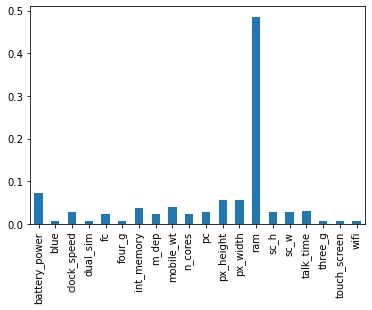

In [9]:
#Forest Example
randFor = RandomForestClassifier()

randFor.fit(X,y)
feat_names = X.columns
for_imp = randFor.feature_importances_
forest_imp = pd.Series(for_imp, index=feat_names)
forest_imp.plot.bar()

In [10]:
#Lasso
lasso = Lasso()
x_reg_dum = pd.get_dummies(Xreg, drop_first=True)
lasso.fit(x_reg_dum, yreg)
coeff = lasso.coef_
print("Zero'd:", np.array(x_reg_dum.columns)[coeff==0])
print("Kept:", np.array(x_reg_dum.columns)[coeff!=0])

Zero'd: ['cyl' 'drat' 'wt' 'qsec' 'vs' 'am' 'gear' 'carb']
Kept: ['disp' 'hp']


### Select from Model

We can use the feature selection aspect of models to do some selection in a direct way. 

In [11]:
#Lasso based 
from sklearn.feature_selection import SelectFromModel
l1_selection = Lasso().fit(x_reg_dum, yreg)
sfm = SelectFromModel(l1_selection, prefit=True)
x_reg_new = sfm.transform(x_reg_dum)
print(x_reg_new.shape)

(32, 2)


In [12]:
#Tree Based
tree_sel = RandomForestClassifier().fit(X, y)
sfm_class = SelectFromModel(tree_sel, prefit=True)
x_new = sfm_class.transform(X)
print(x_new.shape)

(2000, 4)


## Recursive Elimination

Note: Recursion is a common programming concept that basically means to continue to repeat the same thing over and over on a smaller version of the same problem. 

Recursive feature elimination uses recursion to keep removing features, creating a smaller and smaller feature set. So we can basically cut a feature at a time out, create a model, and see how well we're doing. The ranking that we print out assigns all the stuff we keep a 1, and a bigger number to other ones. 

Note: There is also Sequental Feature Selection, which functions similarly, either removing or adding features one at a time. 

In [13]:
from sklearn.feature_selection import RFE
est = LogisticRegression(max_iter=10000, solver="saga")
rfe = RFE(estimator=est, n_features_to_select=12, step=1)
rfe.fit(X, y)
print(rfe.ranking_)
mask = rfe.get_support()
new_features = X.columns[mask]
print(new_features)

[8 1 1 1 2 1 4 1 5 1 3 7 9 6 1 1 1 1 1 1]
Index(['blue', 'clock_speed', 'dual_sim', 'four_g', 'm_dep', 'n_cores', 'sc_h',
       'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi'],
      dtype='object')


We can also step this up and search for the optimal number of features. RFECV will do a cross-validation and give us a breakdown of our accuracy with different numbers of features included. We can see the optimal number, as well as the relative scores for each number of features. 

Optimal number of features : 20
Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi'],
      dtype='object')


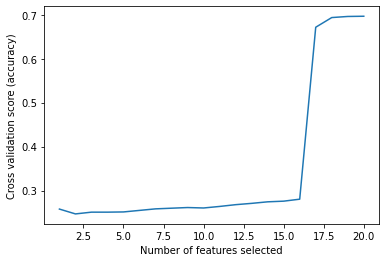

In [14]:
from sklearn.feature_selection import RFECV
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=est,
    step=1,
    cv=3,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)
mask = rfecv.get_support()
new_features = X.columns[mask]
print(new_features)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

### Feature Selection in Pipeline

We can stack this feature selection stuff into a pipeline. 

In [15]:
#Add a pipeline
model = RandomForestClassifier(n_jobs=-1)
pipe_model = LogisticRegression(max_iter=10000, solver="saga")

min_features_to_select = 1  # Minimum number of features to consider
rfecv_pipe = RFECV(
    estimator=pipe_model,
    step=1,
    cv=3,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)

X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y)


pipeline_steps = [("fs", rfecv_pipe),
                ('model', model) ]
pipe = Pipeline(pipeline_steps)
pipe.fit(X_train_, y_train_)
pipe.score(X_test_,y_test_)

0.86

## Exercise - Feature Selection on Pixels

We can try to do some feature selection on the pixels of our number images. The pixels around the edges are pretty much white for every digit, so I suspect that those are somewhat less important than the middle pixels. Remember, each pixel is a feature. 

In [16]:
#Load mnist data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

In [17]:
var_th = VarianceThreshold(.3)
print(X.shape)
post_vt = var_th.fit_transform(X)
print(post_vt.shape)

(70000, 784)
(70000, 685)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X[:2000], y[:2000], test_size=0.3)


In [19]:
b = SelectKBest(chi2, k=15)
kb2 = kb.fit(X_train,y_train)
post_c2 = kb2.transform(X_train)
print(post_c2.shape)

#Print the features
mask = kb2.get_support()
new_features = X_train.columns[mask]
print(new_features)


# Percentile - condensed
post_per = SelectPercentile(chi2, percentile=60).fit_transform(X_train,y_train)
print(post_per.shape)

#Mutual Info
post_mut_inf = SelectPercentile(score_func=mutual_info_classif, percentile=50).fit_transform(X_train,y_train.ravel())
print(post_mut_inf.shape)

(1400, 15)
Index(['pixel101', 'pixel102', 'pixel359', 'pixel387', 'pixel428', 'pixel456',
       'pixel483', 'pixel484', 'pixel511', 'pixel512', 'pixel539', 'pixel540',
       'pixel567', 'pixel568', 'pixel596'],
      dtype='object')
(1400, 470)
(1400, 392)


In [20]:
#Feature selection 1 - e.g. variance thresh
X_train, X_test, y_train, y_test = train_test_split(X[:2000], y[:2000], test_size=0.3)



In [21]:
#Feature selection 2 - e.g. rfecv
#May need to use a subset to keep size manageable. 
from sklearn.feature_selection import RFECV
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=est,
    step=1,
    cv=3,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)
mask = rfecv.get_support()
new_features = X_train.columns[mask]
print(new_features)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [ ]:
#Plot Results

## Feature Selection on Pixels - Sample Solution

We can try to do some feature selection on the pixels of our number images. The pixels around the edges are pretty much white for every digit, so I suspect that those are somewhat less important than the middle pixels. Remember, each pixel is a feature. 

In [ ]:
#Load Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
Xp, yp = mnist["data"], mnist["target"]
print(Xp.shape)
print(yp.shape)

(70000, 784)
(70000,)


Do a simple filter - check the variance. 

In [ ]:
var_pix = VarianceThreshold(.3)
print(Xp.shape)
post_pix = var_pix.fit_transform(Xp)
print(post_pix.shape)

(70000, 784)
(70000, 685)


Use Recursive Feature Selection. 

In [ ]:
min_features = 100
est_img = RandomForestClassifier(n_estimators=30, ccp_alpha=.01, n_jobs=-1)
rfecvp = RFECV(
    estimator=est_img,
    step=1,
    cv=3,
    scoring="f1_weighted",
    min_features_to_select=min_features,
)
rfecvp.fit(Xp[:10000], yp[:10000])

RFECV(cv=3,
      estimator=RandomForestClassifier(ccp_alpha=0.01, n_estimators=30,
                                       n_jobs=-1),
      min_features_to_select=100, scoring='f1_weighted')

Optimal number of features : 530


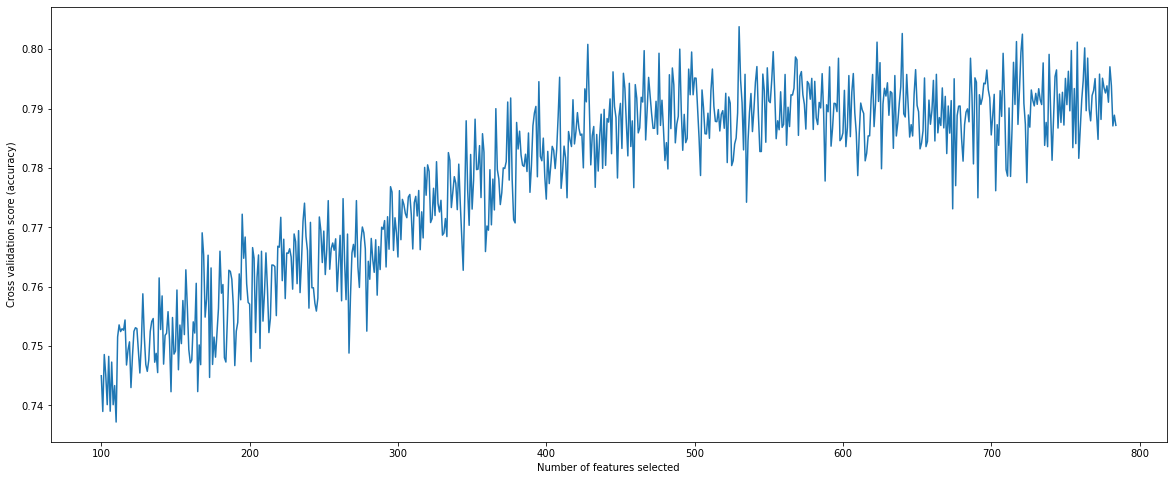

In [ ]:
print("Optimal number of features : %d" % rfecvp.n_features_)
plt.rcParams["figure.figsize"] = (20,8)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features, len(rfecvp.grid_scores_) + min_features),
    rfecvp.grid_scores_,
)
plt.show()

### Results

The exact details will vary a bit, but we can see our accuracy flattening out at some point. We could likely filter out ~250 pixels or so from the data and get similar levels of accuracy. Making models on all 70000 images took a while last time with linear regression, so making a change like this will probably save some noticable processing time. On bigger datasets, with more pixels, and more color, these types of changes can start to add up. 

![Feature Selection](images/feat_sel_pix.png "Feature Selection" )
